<a href="https://colab.research.google.com/github/boyhhy88/Projects/blob/master/Deep%20Learning%20Projects/3.%20Convolutional%20Neural%20Network%20with%20TensorFlow/8.%20Cloud%20Computing%20with%20Google%20Colab/Ipython%20Notebook/Cloud%20Computing%20with%20Google%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Computing with Google Colab

Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory we can write and execute code, save and share our analyses, and access powerful computing resources (like GPU), all for free from our browser.

In this notebook, we will create a convolutional neural network for rock–paper–scissors image classification and train it in the cloud.

In [1]:
%matplotlib inline
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import matplotlib.pyplot as plt
import os, signal
import zipfile
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from keras.preprocessing import image

Using TensorFlow backend.


## 1. Data Pre-Processing

### 1.1 Download Data

#### Download Data from External Link

In [2]:
# download the training data set as a zip file and save it to the "/tmp" folder.
# The -O option sets the output file name. 
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip

--2019-08-24 10:38:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   155MB/s    in 1.2s    

2019-08-24 10:38:58 (155 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]



In [3]:
# download the dev data set as a zip file and save it to the "/tmp" folder.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2019-08-24 10:39:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-test-set.z 100%[===================>]  28.15M  --.-KB/s    in 0.1s    

2019-08-24 10:39:07 (231 MB/s) - ‘/tmp/rps-test-set.zip’ saved [29516758/29516758]



In [0]:
# the folder which saves the data zip file
folder = '/tmp/' # if download from link

#### Download Data from Google Drive

Mount Google Drive in our virtual machine using an authorization code.

In [5]:
from google.colab import drive
drive.mount('/tmp/drive')

Drive already mounted at /tmp/drive; to attempt to forcibly remount, call drive.mount("/tmp/drive", force_remount=True).


In [0]:
# the folder which saves the zip data file
folder = '/tmp/drive/My Drive/Deep Learning/Colab/' # if downloaded from Google Drive

### 1.2 File Pre-Processing

In [0]:
# training dataset
zipfile_path = folder + 'rps.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r')
zip_file.extractall(path = '/tmp/train_rps')

# dev dataset
zipfile_path = folder + 'rps-test-set.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r')
zip_file.extractall(path = '/tmp/dev_rps')

zip_file.close()

The contents of the .zip are extracted to the base directory `/tmp/train_rps` (for training) and `/tmp/dev_rps` (for dev), which in turn each contain `paper`, `rock`  and `scissors` subdirectories.

We do not explicitly label the images. We'll use Image Generator -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. 

In [0]:
# Directories with our training and dev data

train_paper_dir = os.path.join('/tmp/train_rps/rps/paper')
train_rock_dir = os.path.join('/tmp/train_rps/rps/rock')
train_scissors_dir = os.path.join('/tmp/train_rps/rps/scissors')

dev_paper_dir = os.path.join('/tmp/dev_rps/rps-test-set/paper')
dev_rock_dir = os.path.join('/tmp/dev_rps/rps-test-set/rock')
dev_scissors_dir = os.path.join('/tmp/dev_rps/rps-test-set/scissors')

Let's find out the total number of images in the directories:

In [9]:
train_paper_fnames = os.listdir(train_paper_dir)
train_rock_fnames = os.listdir(train_rock_dir)
train_scissors_fnames = os.listdir(train_scissors_dir)

dev_paper_fnames = os.listdir(dev_paper_dir)
dev_rock_fnames = os.listdir(dev_rock_dir)
dev_scissors_fnames = os.listdir(dev_scissors_dir)

print('Total training paper images:', len(train_paper_fnames))
print('Total training rock images:', len(train_rock_fnames))
print('Total training scissors images:', len(train_scissors_fnames))

print('Total dev paper images:', len(dev_paper_fnames))
print('Total dev rock images:', len(dev_rock_fnames))
print('Total dev scissors images:', len(dev_scissors_fnames))

Total training paper images: 840
Total training rock images: 840
Total training scissors images: 840
Total dev paper images: 124
Total dev rock images: 124
Total dev scissors images: 124


### 1.3 Image Data Examples

Now let's take a look at a few pictures to get a better sense of what they look like.

In [0]:
# Parameters for our graph; we'll output images in a nrows x ncols configuration

nrows = 6
ncols = 4

train_paper_paths = [os.path.join(train_paper_dir, fname) for fname in train_paper_fnames]
train_rock_paths = [os.path.join(train_rock_dir, fname) for fname in train_rock_fnames]
train_scissors_paths = [os.path.join(train_scissors_dir, fname) for fname in train_scissors_fnames]
dev_paper_paths = [os.path.join(dev_paper_dir, fname) for fname in dev_paper_fnames]
dev_rock_paths = [os.path.join(dev_rock_dir, fname) for fname in dev_rock_fnames]
dev_scissors_paths = [os.path.join(dev_scissors_dir, fname) for fname in dev_scissors_fnames]

Display a batch of 8 paper, 8 rock and 8 scissors images.

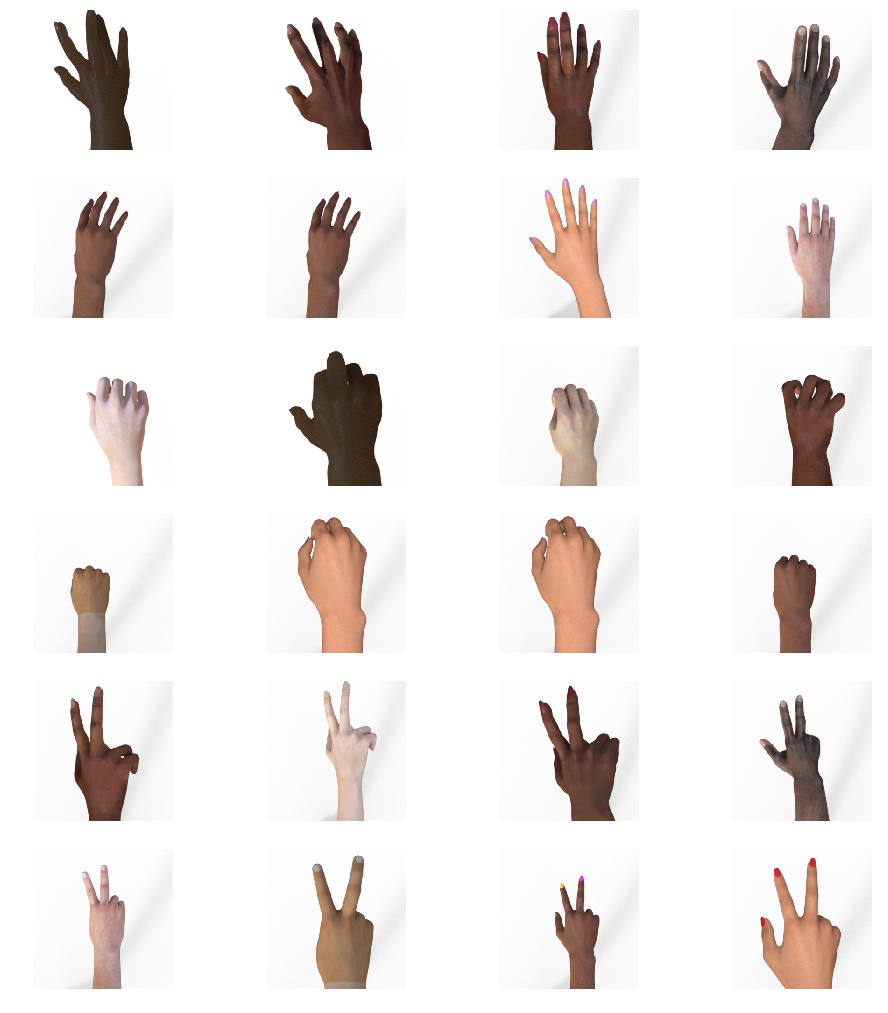

In [11]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

# iterating over 24 images
for i, img_path in enumerate(train_paper_paths[0:4] + dev_paper_paths[0:4] + train_rock_paths[0:4] + dev_rock_paths[0:4] 
                             + train_scissors_paths[0:4] + dev_scissors_paths[0:4]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)

### 1.4. Image Data Augmentation and Generator

In [12]:
# create image data

# training set with image data augmentation
train_gen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
train_generator = train_gen.flow_from_directory(
    '/tmp/train_rps/rps/',  # This is the source directory for training images
    target_size = (150, 150),  # All images will be resized
    class_mode = 'categorical') 

# dev set
dev_gen = ImageDataGenerator(rescale = 1. / 255)
dev_generator = dev_gen.flow_from_directory(
    '/tmp/dev_rps/rps-test-set/',  # This is the source directory for dev images
    target_size = (150, 150),  # All images will be resized
    class_mode = 'categorical')

print("Class index: "  + str(train_generator.class_indices))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Class index: {'paper': 0, 'rock': 1, 'scissors': 2}


## 2. Build the CNN Model

We add convolutional and pooling layers, and then flatten the result to feed into densely connected layers.

In [0]:
model = tf.keras.models.Sequential([
    # The first convolution and pooling
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution and pooling
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution and pooling
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution and pooling
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # add dropout layer
    tf.keras.layers.Dropout(rate = 0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    # Output layer
    tf.keras.layers.Dense(3, activation = 'softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 1e-4),
              metrics = ['acc'])

## 3. Model Training

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') > 0.98):
            print("\nReached target accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [17]:
history = model.fit_generator(
    train_generator,
    epochs = 25,
    verbose = 1,
    validation_data = dev_generator,
    callbacks = [callbacks])

Epoch 1/25
79/79 [==============================] - 21s 262ms/step - loss: 1.0671 - acc: 0.4143 - val_loss: 0.8884 - val_acc: 0.6102
Epoch 2/25
79/79 [==============================] - 18s 230ms/step - loss: 0.8827 - acc: 0.5913 - val_loss: 0.5876 - val_acc: 0.9247
Epoch 3/25
79/79 [==============================] - 18s 232ms/step - loss: 0.6909 - acc: 0.7194 - val_loss: 0.3860 - val_acc: 0.8360
Epoch 4/25
79/79 [==============================] - 18s 232ms/step - loss: 0.5636 - acc: 0.7762 - val_loss: 0.3201 - val_acc: 0.8710
Epoch 5/25
79/79 [==============================] - 18s 229ms/step - loss: 0.4804 - acc: 0.8175 - val_loss: 0.2102 - val_acc: 0.9220
Epoch 6/25
79/79 [==============================] - 18s 229ms/step - loss: 0.4224 - acc: 0.8444 - val_loss: 0.1683 - val_acc: 0.9570
Epoch 7/25
79/79 [==============================] - 18s 232ms/step - loss: 0.3807 - acc: 0.8599 - val_loss: 0.3353 - val_acc: 0.8360
Epoch 8/25
79/79 [==============================] - 18s 232ms/step - 

#### Plot the training progress

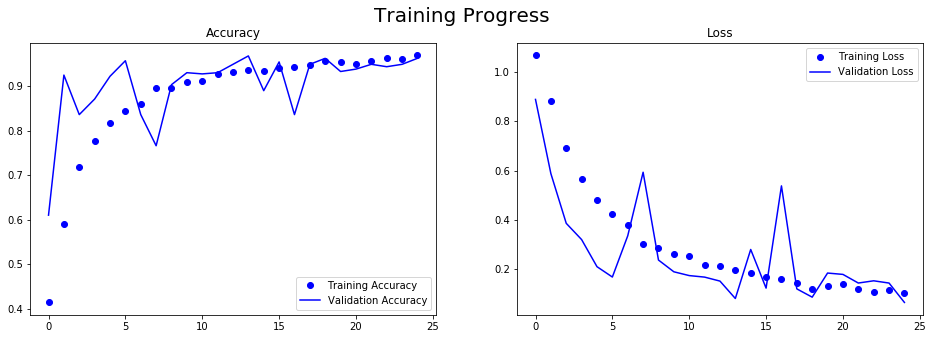

In [18]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
epochs = range(len(train_acc))

fig, axes = plt.subplots(1, 2)
fig.suptitle('Training Progress', fontsize = 20)
fig.set_size_inches(16, 5)
axes[0].plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
axes[0].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(epochs, train_loss, 'bo', label = 'Training Loss')
axes[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
axes[1].set_title('Loss')
axes[1].legend()
plt.show()

## 4. Model Testing

Let's now take a look at actually running a prediction using the model. This code will allow us to choose one or more files from our file system, it will then upload them, and run
them through the model, giving an indication of whether the object is rock, paper or scissors.

Saving paper3.png to paper3.png
Saving rock5.png to rock5.png
Saving scissors-hires1.png to scissors-hires1.png
Prediction:[[9.9919707e-01 3.5891432e-08 8.0299174e-04]]
Prediction:[[2.0382703e-04 9.7035855e-01 2.9437628e-02]]
Prediction:[[2.936445e-06 6.132690e-08 9.999970e-01]]


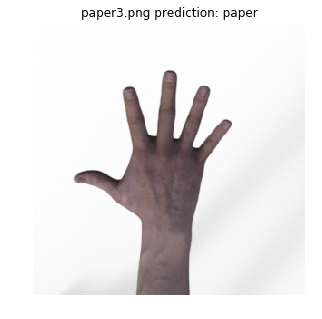

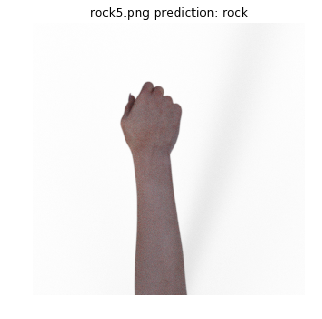

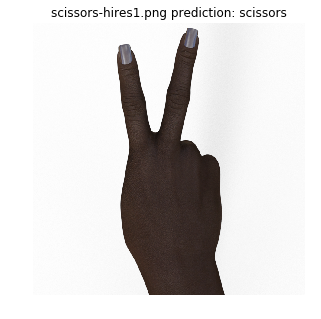

In [21]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    file = '/content/' + fn
    img = image.load_img(file, target_size = (150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x /= 255
    
    # predict
    classes = model.predict(x)
    print('Prediction:' + str(classes))
    
    # show the figure with prediction
    image_cur = plt.imread(file)
    plt.figure(figsize = (5, 5))
    plt.imshow(image_cur)
    plt.axis('off')
    if np.argmax(classes) == 0:
        plt.title(file.split('/')[-1] + " prediction: paper")
    elif np.argmax(classes) == 1:
        plt.title(file.split('/')[-1] + " prediction: rock")
    else:
        plt.title(file.split('/')[-1] + " prediction: scissors")

## 5. Visualizing Intermediate Representations

We randomly pick an image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map.

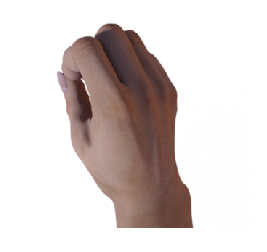

In [22]:
# Define a new model that will take an image as input, and will output intermediate representations for all layers in
# the previous model
outputs = [layer.output for layer in model.layers]
vis_model = Model(inputs = model.input, outputs = outputs)

# Get a random input image from the training set.
random.seed(0)
img_path = random.choice(train_paper_paths + train_rock_paths + train_scissors_paths)
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')

img = image.load_img(img_path, target_size = (150, 150)) # this is a PIL image
x = image.img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)
x /= 255

# Let's run our image through our network, thus obtaining all intermediate representations for this image.
feature_maps = vis_model.predict(x)
# Get the names of the layers
layer_names = [layer.name for layer in model.layers]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


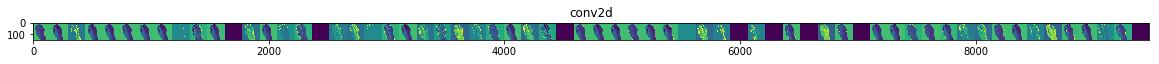

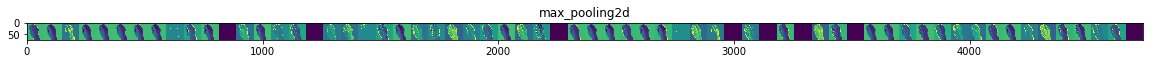

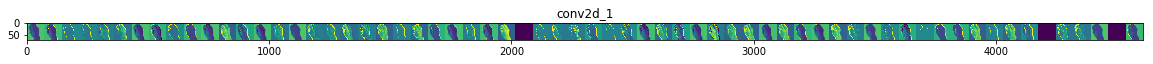

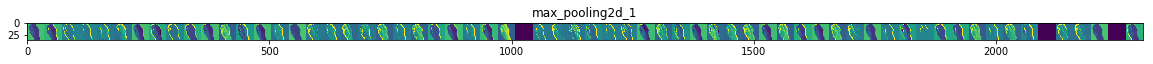

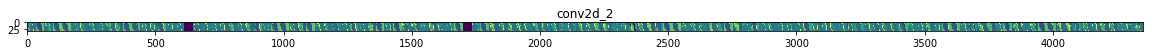

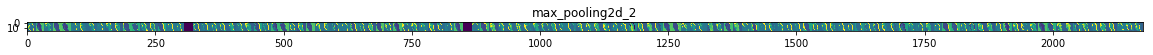

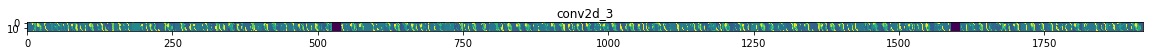

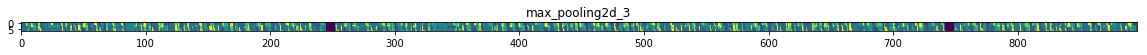

In [23]:
# Now let's display our representations

for layer_name, feature_map in zip(layer_names, feature_maps):
    # Only for the conv / pooling layers, not the fully-connected layers
    if len(feature_map.shape) == 4:
        n_channels = feature_map.shape[-1] # number of channels in current feature map
        # The feature map has shape (1, size, size, n_channels)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_channels))
        # Postprocess the feature to make it visually palatable
        for i in range(n_channels):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
            # Display the grid
        height = 20. / n_channels # figure height
        plt.figure(figsize = (height * n_channels, height)) # each small figure has the same height and width
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

It is hard to see the pictures of a layer when the number of channels is too large. In the following code, we only plot the first 10 channels for each layer.

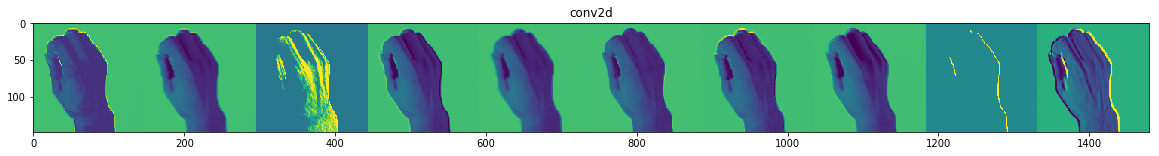

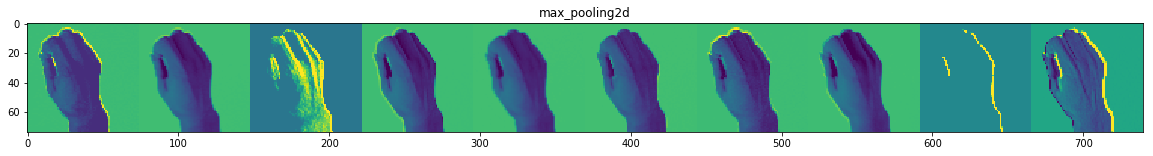

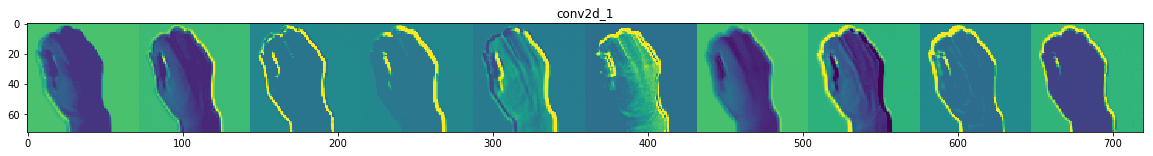

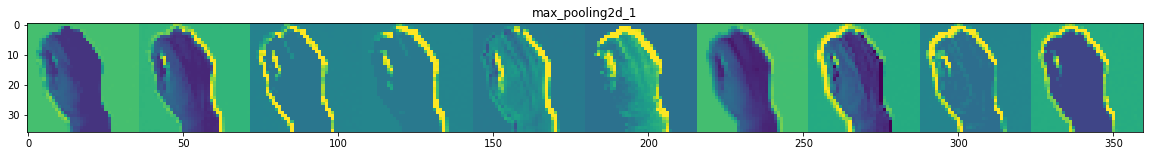

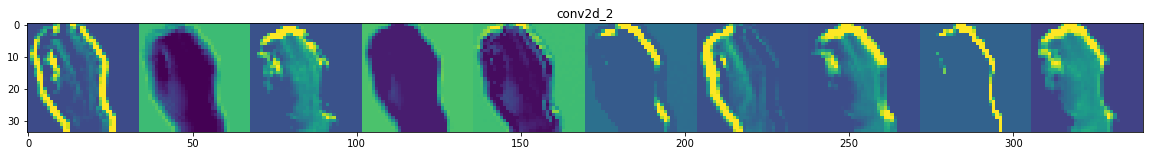

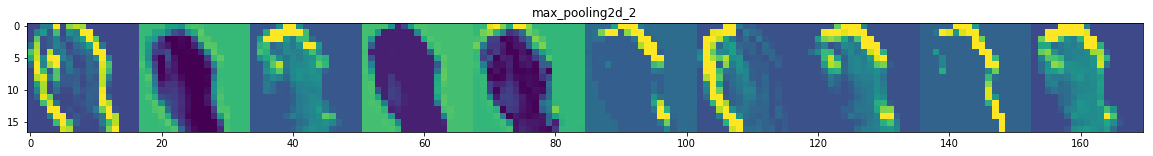

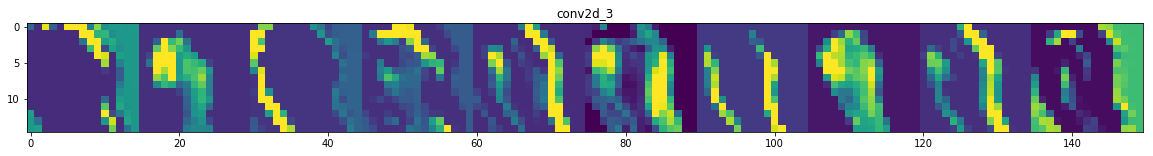

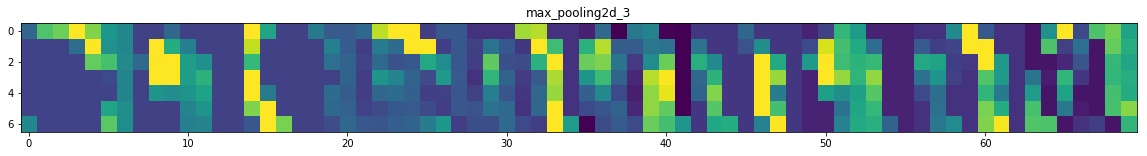

In [24]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:
        n_channels = 10
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_channels))
        for i in range(n_channels):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        height = 20. / n_channels # figure height
        plt.figure(figsize = (height * n_channels, height)) 
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 6. Clean Up
Run the following cell to terminate the kernel and free memory resources.


In [0]:
#os.kill(os.getpid(), signal.SIGKILL)